# making pretty graphs

In [16]:
import pydot
from IPython.display import Image, display

In [2]:
from Env.DC_gym_reward import DC_gym_reward as DC_Gym
from Env.STANDARD_CONFIG import CONFIG
standard_args = CONFIG(1).get_config()
env=DC_Gym(*standard_args)

C:\Users\meatrobot\miniconda3\envs\TF\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [7]:
env.reset()

array([[1.        , 0.74725273, 1.        , 0.74725273, 0.74725273,
        0.74725273, 1.        , 1.        ]])

In [15]:
action_continuous = env.sample()[0]

In [22]:
env.step((action_continuous, 0))

(array([[0.00000000e+00, 0.00000000e+00, 4.92321715e-02, 0.00000000e+00,
         1.96211851e-02, 1.18681308e-06, 8.01907631e-01, 4.14000000e-01]]),
 array([[0.        , 0.        , 0.03775965, 0.        , 0.01231239,
         0.74699598, 0.90094242, 0.414     ]]),
 0,
 -27.0,
 False,
 {})

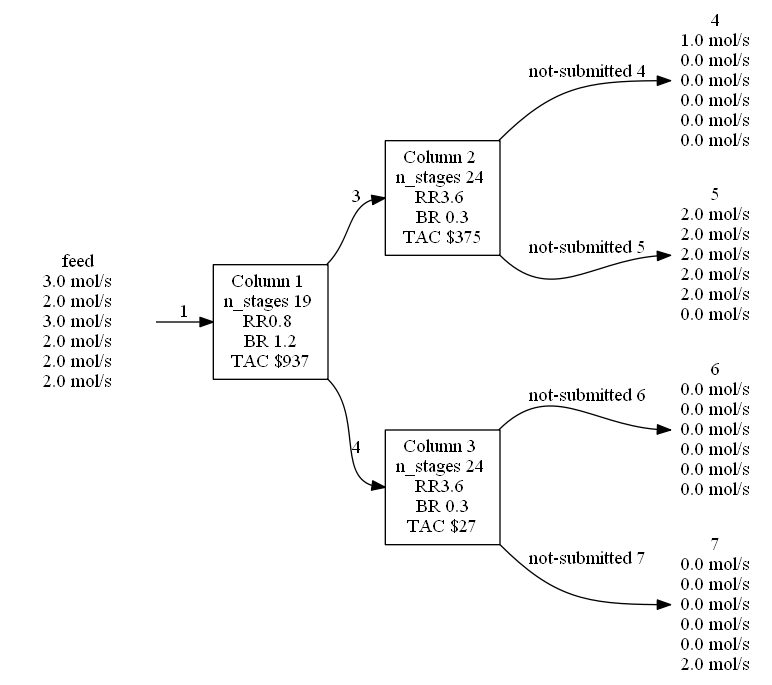

In [56]:
x = Visualiser(env)
x.visualise()

In [55]:
import pydot
from IPython.display import Image, display

class Visualiser:
    def __init__(self, env):
        self.env = env

    def visualise(self, show_all=True):
        space = " "
        G = pydot.Dot(graph_type="digraph", rankdir="LR")
        outlet_nodes = []
        nodes = []
        edges = []
        image_list = []
        if show_all is True:
            feed_string = "feed \n" + "".join([f"{round(flow)} mol/s \n" for flow in self.env.original_feed.flows])
        else:
            feed_string = " "
        feed_node = pydot.Node(feed_string, shape="square", color="white")
        G.add_node(feed_node)
        for i, column_info in enumerate(self.env.State.column_data):
            label = f'Column {i + 1} \nn_stages {column_info.n_stages} \nRR' +  str(round(column_info.reflux_ratio, 1)) + ' \n' + \
                    f"BR " + str(round(column_info.reboil_ratio, 1)) + f"\nTAC ${int(column_info.TAC)}"
            nodes.append(pydot.Node(label, shape="square"))
            G.add_node(nodes[i])
            if i > 0:
                stream_in = column_info.inlet_number
                column_link, loc = self.find_column(stream_in)
                edges.append(pydot.Edge(nodes[column_link], nodes[i], label=int(stream_in + 1), headport="w",
                                        tailport=loc))
                G.add_edge(edges[i - 1])
            else:
                G.add_edge(pydot.Edge(feed_node, nodes[0], label=1, headport="w", tailport="e"))

        # add outlet streams
        for outlet_stream in self.env.State.final_outlet_streams:
            label = f"{outlet_stream.number} \n" + \
            "".join([f"{round(flow)} mol/s \n" for flow in outlet_stream.flows])
            column_link, loc = self.find_column(outlet_stream.number)
            outlet_nodes.append(
                pydot.Node(label, shape="box", color="white"))
            G.add_node(outlet_nodes[-1])
            G.add_edge(pydot.Edge(nodes[column_link], outlet_nodes[-1], label=f" Submitted {outlet_stream.number}"
                                  ,headport="w", tailport=loc))

        for outlet_stream in self.env.State.streams:
            label = f"{outlet_stream.number} \n" + \
            "".join([f"{round(flow)} mol/s \n" for flow in outlet_stream.flows])
            column_link, loc = self.find_column(outlet_stream.number)
            outlet_nodes.append(
                pydot.Node(label, shape="box", color="white"))
            G.add_node(outlet_nodes[-1])
            G.add_edge(pydot.Edge(nodes[column_link], outlet_nodes[-1], label=f" not-submitted {outlet_stream.number}"
                                  ,headport="w", tailport=loc))
        plt = Image(G.create_png())
        display(plt)
        return G

    def find_column(self, stream):
        for i, column_info in enumerate(self.env.State.column_data):
            if stream == column_info.tops_number:
                loc = "ne"
                return i, loc
            elif stream == column_info.bottoms_number:
                loc = "se"
                return i, loc

In [13]:
G = pydot.Dot(graph_type="digraph", rankdir="LR")
outlet_nodes = []
nodes = []
edges = []

In [8]:
feed_string = "".join([f"{round(flow)} mol/s \n" for flow in env.original_feed.flows])
print(feed_string)

3.0 mol/s 
2.0 mol/s 
3.0 mol/s 
2.0 mol/s 
2.0 mol/s 
2.0 mol/s 



In [14]:
feed_node = pydot.Node(feed_string, shape="square", color="white")
G.add_node(feed_node)

In [20]:
new_node = pydot.Node("Column 1", shape="square")
G.add_node(new_node)
new_edge = pydot.Edge(feed_node, new_node, label="stream 1", headport="w")
G.add_edge(new_edge)

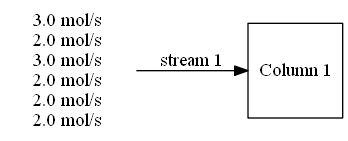

In [21]:
plt = Image(G.create_png())
display(plt)

# Agent file debug

In [1]:
from Utils.memory import Memory
from Nets_batch.Critic import Critic
from Nets_batch.P_actor import ParameterAgent
from Env.DC_gym_reward import DC_gym_reward as DC_Gym
from Env.STANDARD_CONFIG import CONFIG
import numpy as np
from tensorflow.keras.models import clone_model
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
standard_args = CONFIG(1).get_config()
env=DC_Gym(*standard_args)

C:\Users\meatrobot\miniconda3\envs\TF\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
model, opt = ParameterAgent(0.1, env.continuous_action_space.shape[0], env.observation_space.shape).build_network()

In [4]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 1, 8)]            0         
_________________________________________________________________
dense1 (Dense)               (None, 1, 512)            4608      
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 512)            2048      
_________________________________________________________________
dense2 (Dense)               (None, 1, 512)            262656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 512)            2048      
_________________________________________________________________
dense3 (Dense)               (None, 1, 512)            262656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 512)            2048  

# Runtime File

In [ ]:
# runtime per episode (9 min / 5 episode average) is less than 2 (1.8 min) min per episode
# runtime per episode (5.5 min / 5 episode average) almost 1 min per episode
# tensorboard --logdir logs
from Workers.Agent_target import Agent
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime
import time

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'BatchMemory_Agent/' + 'logs/' + " with targets" + current_time
summary_writer = tf.summary.create_file_writer(log_dir)

Agent = Agent(summary_writer=summary_writer, total_episodes=10, mem_length=10, batch_size=5)